In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_91,Feature_92,Feature_93,Feature_94,Feature_95,Feature_96,Feature_97,Feature_98,Feature_99,Feature_100
0,1,2,2,56.0,12,1,7.0,4.0,0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2,2,2,69.0,19,1,6.0,4.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,1,66.0,8,1,4.0,4.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2,2,62.0,16,1,NaN,3.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,2,67.0,30,1,NaN,4.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df = df_init.copy()

target_name = 'Result'
golden_features = ['Feature_3', 'Feature_4', 'Feature_32', 'Feature_35']
feature_names = df.columns.drop([target_name] + golden_features + ['Id']).tolist()

df = df[[target_name] + feature_names]
df.fillna(0, inplace=True)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Result,143.0,1.685315,0.466023,1.0,1.0,2.0,2.0,2.0
Feature_1,143.0,1.496503,0.501745,1.0,1.0,1.0,2.0,2.0
Feature_2,143.0,66.594406,15.666973,0.0,56.0,68.0,80.0,97.0
Feature_5,143.0,2.664336,3.126317,0.0,0.0,1.0,5.0,12.0
Feature_6,143.0,2.839161,0.801850,0.0,2.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...
Feature_96,143.0,0.300699,1.156945,0.0,0.0,0.0,0.0,9.0
Feature_97,143.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Feature_98,143.0,0.041958,0.201198,0.0,0.0,0.0,0.0,1.0
Feature_99,143.0,0.265734,0.887718,0.0,0.0,0.0,0.0,9.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 97 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Result       143 non-null    int64  
 1   Feature_1    143 non-null    int64  
 2   Feature_2    143 non-null    float64
 3   Feature_5    143 non-null    float64
 4   Feature_6    143 non-null    float64
 5   Feature_7    143 non-null    int64  
 6   Feature_8    143 non-null    float64
 7   Feature_9    143 non-null    float64
 8   Feature_10   143 non-null    float64
 9   Feature_11   143 non-null    float64
 10  Feature_12   143 non-null    float64
 11  Feature_13   143 non-null    float64
 12  Feature_14   143 non-null    float64
 13  Feature_15   143 non-null    float64
 14  Feature_16   143 non-null    int64  
 15  Feature_17   143 non-null    float64
 16  Feature_18   143 non-null    float64
 17  Feature_19   143 non-null    int64  
 18  Feature_20   143 non-null    int64  
 19  Feature_

In [6]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.1,
    random_state=0,
    stratify=y
)

train_pool = Pool(
    X_train,
    y_train
)

test_pool = Pool(
    X_test,
    y_test
)

params_model = {
    'auto_class_weights': 'Balanced',
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 50,
}

cbr_model = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400, 600, 800, 1000, 1200],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2, 2.5]
}

rs = cbr_model.randomized_search(
    params_grid,
    train_pool,
    n_iter=10,
    shuffle=True,
    stratified=True,
    partition_random_seed=0,
    cv=5,
    # cv=StratifiedKFold(
    #     n_splits=5,
    #     shuffle=True,
    #     random_state=0
    # ),
    calc_cv_statistics=True,
    search_by_train_test_split=False,
    refit=True,
)

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.8239592	best: 0.8239592 (0)	total: 12.6s	remaining: 1m 53s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.7772423	best: 0.8239592 (0)	total: 18.5s	remaining: 1m 14s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.8181464	best: 0.8239592 (0)	total: 29.9s	remaining: 1m 9s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.7869325	best: 0.8239592 (0)	total: 37.6s	remaining: 56.4s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.7705007	best: 0.8239592 (0)	total: 1m 13s	remaining: 1m 13s
Stopped by overfitting detector  (50 iterations wait)
5:	loss: 0.7672599	best: 0.8239592 (0)	total: 2m 23s	remaining: 1m 35s
Stopped by overfitting detector  (50 iterations wait)
6:	loss: 0.7803858	best: 0.8239592 (0)	total: 2m 27s	remaining: 1m 3s
Stopped by overfitting detector  (50 iterations wait)
7:	loss: 0.7833474	best: 0.8239592 (0)	total: 2m 35s	remaining: 38.8s
Stopped 

In [7]:
print(f'Accuracy on train: {round(cbr_model.score(train_pool), 2)}')
print(f'Accuracy on test: {round(cbr_model.score(test_pool), 2)}')

y_test_pred = cbr_model.predict(X_test)
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')
print(f'\nConfusion matrix:\n {confusion_matrix(y_test, y_test_pred)}')

Accuracy on train: 1.0
Accuracy on test: 0.87

Classification report: 
              precision    recall  f1-score   support

           1       0.80      0.80      0.80         5
           2       0.90      0.90      0.90        10

    accuracy                           0.87        15
   macro avg       0.85      0.85      0.85        15
weighted avg       0.87      0.87      0.87        15


Confusion matrix:
 [[4 1]
 [1 9]]


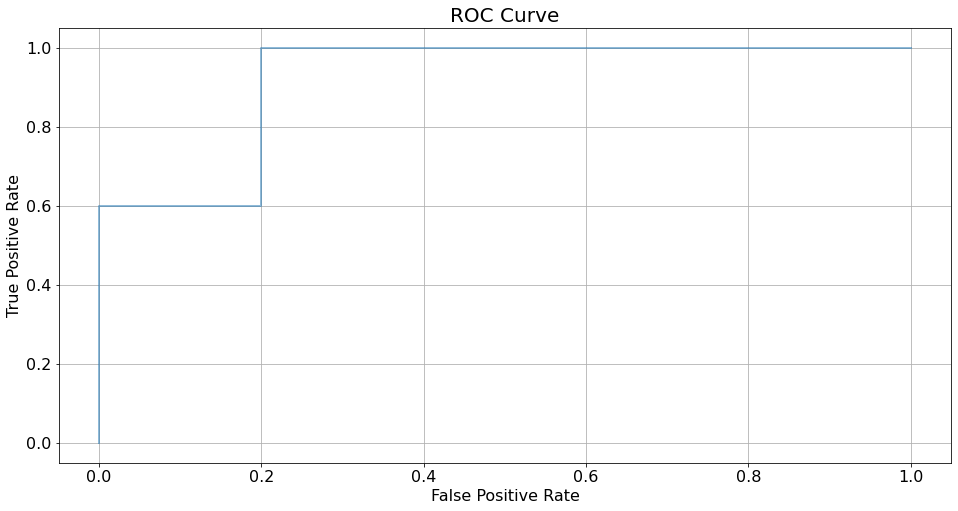

In [8]:
roc_curve_values = get_roc_curve(cbr_model, test_pool, plot=True)

In [9]:
feature_importances = pd.DataFrame(
    zip(X.columns, cbr_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
65,Feature_70,16.184381
26,Feature_29,5.844581
36,Feature_41,5.358122
30,Feature_34,5.220451
35,Feature_40,4.910689
94,Feature_99,4.235866
66,Feature_71,4.142268
42,Feature_47,3.508938
27,Feature_30,2.988601
1,Feature_2,2.864701
